<a href="https://colab.research.google.com/github/rroxy08/CE888/blob/master/assignment1/covariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random as rd
import os
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from scipy.ndimage.filters import gaussian_filter

#drive.mount('/content/gdrive')
os.environ['KAGGLE_USERNAME'] = "khaledabegum"
os.environ['KAGGLE_KEY'] = "d51b08acbd052ca7a4b2f21e76aa0e6f"


In [2]:
!kaggle competitions download --force -c sberbank-russian-housing-market


  0% 0.00/4.46M [00:00<?, ?B/s]
100% 4.46M/4.46M [00:00<00:00, 69.9MB/s]
  0% 0.00/66.5k [00:00<?, ?B/s]
100% 66.5k/66.5k [00:00<00:00, 45.2MB/s]
  0% 0.00/18.6k [00:00<?, ?B/s]
100% 18.6k/18.6k [00:00<00:00, 12.4MB/s]
 53% 9.00M/17.1M [00:00<00:00, 78.3MB/s]
100% 17.1M/17.1M [00:00<00:00, 105MB/s] 
  0% 0.00/25.4k [00:00<?, ?B/s]
100% 25.4k/25.4k [00:00<00:00, 12.8MB/s]


In [3]:
from zipfile import ZipFile

#file_names = ["/content/train_v2.csv.zip","/content/test_v2.csv.zip"]
file_names = ["/content/train.csv.zip","/content/test.csv.zip"]
for file_name in file_names:
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('done')

done
done


In [4]:
root_path1 = '/content/train.csv' 
root_path2 = '/content/test.csv' 
df_train=pd.read_csv(root_path1)
df_test=pd.read_csv(root_path2)
#df_tr=df_train.sample(10000)
#if "socialEngagementType" in df_tr.columns:
  #del df_tr["socialEngagementType"]
df_tr=df_train.copy()
df_ts=df_test.copy()
df_tr.count

<bound method DataFrame.count of           id   timestamp  ...  market_count_5000  price_doc
0          1  2011-08-20  ...                  4    5850000
1          2  2011-08-23  ...                 14    6000000
2          3  2011-08-27  ...                 10    5700000
3          4  2011-09-01  ...                  3   13100000
4          5  2011-09-05  ...                 14   16331452
...      ...         ...  ...                ...        ...
30466  30469  2015-06-30  ...                  6    7400000
30467  30470  2015-06-30  ...                 15   25000000
30468  30471  2015-06-30  ...                  1    6970959
30469  30472  2015-06-30  ...                  7   13500000
30470  30473  2015-06-30  ...                 10    5600000

[30471 rows x 292 columns]>

In [5]:
df_tr.head()
#df_tr.shape

#df_tr[['full_sq','raion_popul']].plot.hist()
#df_ts[['full_sq','raion_popul']].plot.hist()
#df_ts['build_year'].dtypes

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,...,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,...,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,no,0,0,1,no,no,no,yes,no,no,no,...,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,NaN,1,0,17,6,no,0,11,4,no,no,no,no,no,no,no,...,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,no,0,10,93,no,no,no,yes,yes,no,no,...,853.03,1410.45,1131.74,63,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14,16331452


In [6]:
#preprocessing of data, fillup the NAN value. Since 'year' data types are float so mode is used to fill NAN samples.

for i in df_tr.columns:
    if (df_tr[i].dtype == 'object'or df_tr[i].dtype == 'float'):
      df_tr[i] = df_tr[i].fillna(df_tr[i].mode().iloc[0])
    if (df_tr[i].dtype == 'int'):
      df_tr[i] = df_tr[i].fillna(np.mean(df_tr[i]))

for i in df_ts.columns:
    if (df_ts[i].dtype == 'object' or df_ts[i].dtype == 'float'):
      df_ts[i] = df_ts[i].fillna(df_ts[i].mode().iloc[0])
    if (df_ts[i].dtype == 'int'):
      df_ts[i] = df_ts[i].fillna(np.mean(df_ts[i]))

## Label encoding for string/categorical values
number = LabelEncoder()
for i in df_tr.columns:
    if (df_tr[i].dtype == 'object'):
      df_tr[i] = number.fit_transform(df_tr[i].astype('str'))
      df_tr[i] = df_tr[i].astype('object')

for i in df_ts.columns:
    if (df_ts[i].dtype == 'object'):
      df_ts[i] = number.fit_transform(df_ts[i].astype('str'))
      df_ts[i] = df_ts[i].astype('object')

df_tr.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,0,43,27.0,4.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,9,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,0,0,16,1,0,0,0,0,0,0,0,...,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000
1,2,1,34,19.0,3.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,70,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,1,1,3,0,0,0,0,0,0,0,0,...,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000
2,3,2,43,29.0,2.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,129,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,0,0,0,1,0,0,0,1,0,0,0,...,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000
3,4,3,89,50.0,9.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,65,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,540.0,1,0,17,6,0,0,11,4,0,0,0,0,0,0,0,...,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000
4,5,4,77,77.0,4.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,6,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,0,0,10,93,0,0,0,1,1,0,0,...,853.03,1410.45,1131.74,63,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14,16331452


In [0]:
df_ts.head()
#df_tr['price_doc'].value_counts()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,0,39.0,20.7,2,9,1,1998.0,1,8.9,3.0,0,38,2.615514e+07,178264,0.137846,0.041116,14080,11926.0,11,14892,24750.0,13,1,750.0,1,0,13,4,0,0,4,4,0,0,0,0,0,0,0,...,12,781.82,1227.27,1004.55,1,2,2,7,0,0,0,1,3,1,0,7,0,21.58,4.69,1,37550,8,299166,19,676.47,1088.24,882.35,2,5,4,8,0,0,0,1,10,1,0,14,1
1,30475,0,79.2,1.0,8,17,1,0.0,3,1.0,1.0,1,102,2.553630e+07,4001,0.496315,0.007122,275,3953.0,0,264,9700.0,0,0,750.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,10,680.00,1200.00,940.00,0,1,6,2,1,0,0,1,5,0,0,7,0,39.10,7.70,2,177300,6,231300,20,733.33,1250.00,991.67,2,4,8,4,1,1,0,2,11,0,1,12,1
2,30476,0,40.5,25.1,3,5,2,1960.0,2,4.8,2.0,0,84,9.946335e+06,139322,0.065409,0.225825,6400,2232.0,7,6558,7966.0,7,0,1548.0,3,0,13,0,0,0,2,7,1,0,1,1,0,0,0,...,37,608.33,1069.44,838.89,1,8,19,7,2,0,0,2,3,0,5,22,4,25.62,13.59,27,427889,26,1024431,179,668.97,1132.18,900.57,5,53,64,42,11,4,0,10,21,0,10,71,11
3,30477,0,62.8,36.0,17,17,1,2016.0,2,62.8,3.0,1,104,2.149409e+07,7122,0.262459,0.017647,489,3953.0,0,469,9700.0,0,0,750.0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,...,1,300.00,500.00,400.00,0,1,0,0,0,0,0,0,4,0,0,0,0,24.25,1.66,0,0,0,0,5,1560.00,2500.00,2030.00,0,1,0,1,1,2,0,0,10,0,0,2,0
4,30478,0,40.0,40.0,17,17,1,0.0,1,1.0,1.0,1,102,2.553630e+07,4001,0.496315,0.007122,275,3953.0,0,264,9700.0,0,0,750.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,9,700.00,1222.22,961.11,0,1,5,2,1,0,0,1,4,0,0,6,0,35.62,6.96,1,117300,4,201300,20,747.37,1263.16,1005.26,1,4,8,5,1,1,0,2,12,0,1,11,1


In [0]:
def return_intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

def compute_kl_divergence(p,q):
    
    kl_div = 0.0
    len=np.size(p)
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
       
    for i in range(len):
      #p[i]=p[i]+0.00001
      #q[i]=q[i]+0.00001  
                     
      if(q[i]!=0.0 and p[i]!=0):
        kl_div+=p[i]*(np.log(p[i]/q[i]))                 
    return kl_div  

In [0]:
training = df_tr.sample(7600, random_state=12) 
testing = df_ts.sample(7600,random_state=11) 
if('id' in training.columns):
  del training['id']
if('price_doc' in training.columns):
  del training['price_doc']
if('id' in testing.columns):
  del testing['id']
  
  


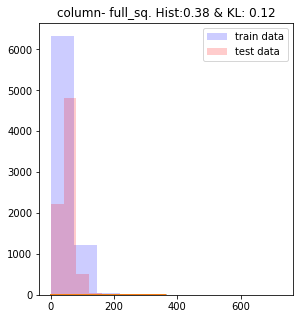

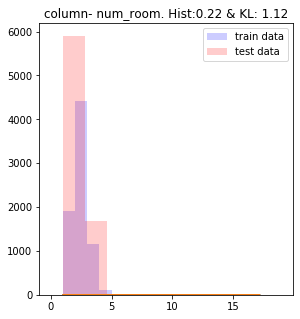

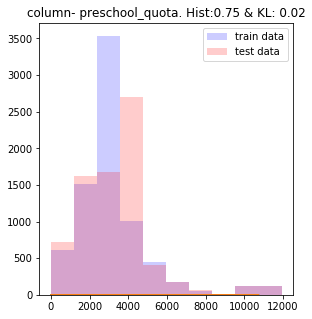

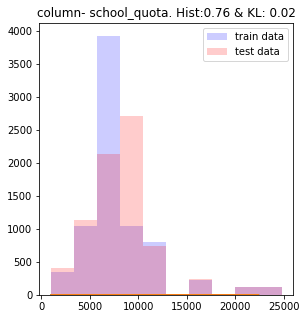

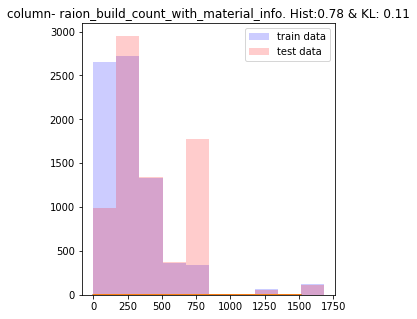

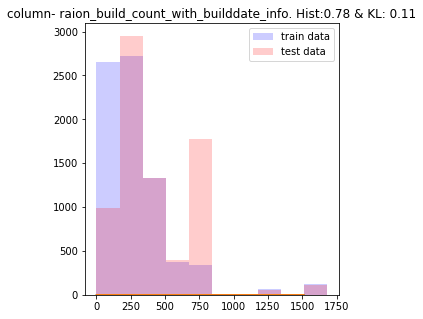

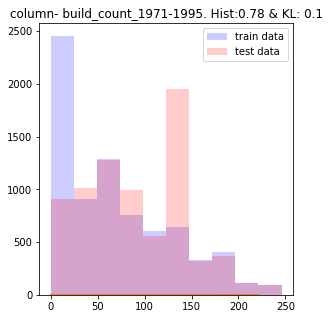

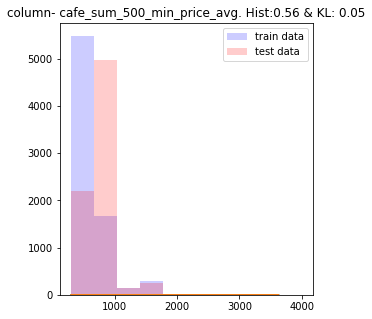

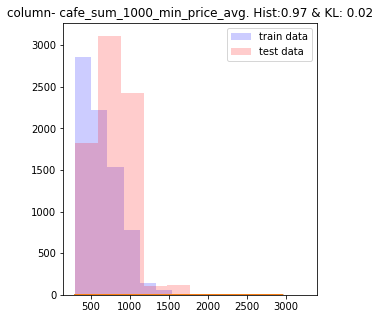

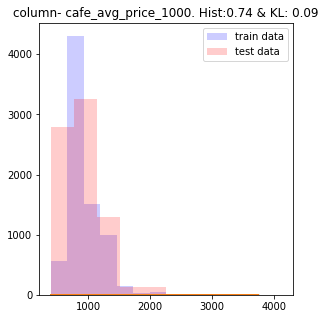

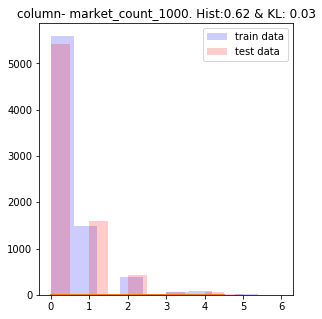

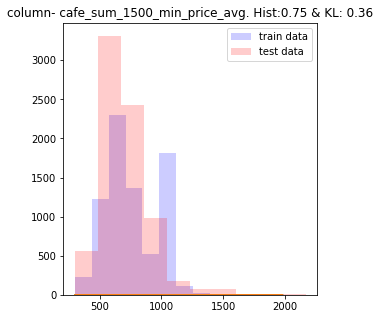

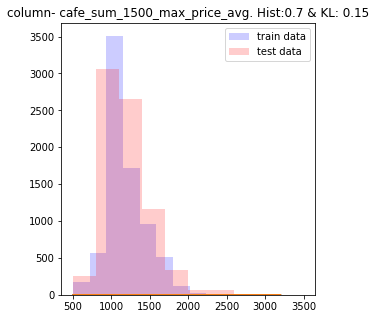

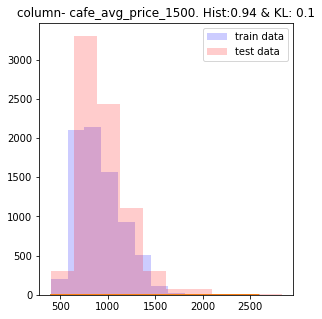

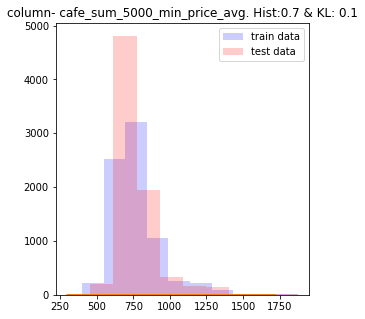

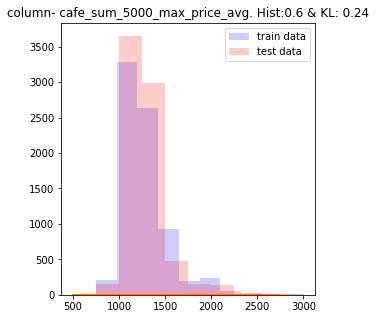

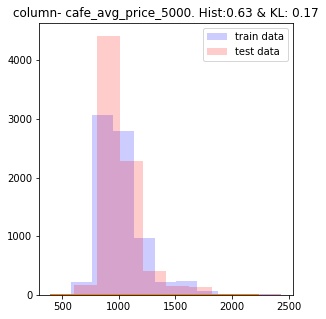

In [9]:
features=['full_sq', 'num_room', 'preschool_quota', 'school_quota', 'raion_build_count_with_material_info', 'raion_build_count_with_builddate_info', 'build_count_1971-1995', 'cafe_sum_500_min_price_avg', 'cafe_sum_1000_min_price_avg', 'cafe_avg_price_1000', 'market_count_1000', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500', 'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000']
sigma=1
bin_val = 10
i=0 
sigma=1
x = np.linspace( 0, 10, 7600)
for col in training[features].columns: 
  hist_1, bins = np.histogram(training[col], bins=bin_val,density=True) 
  hist_2, bins = np.histogram(testing[col], bins=bin_val,density=True)
  
  hist_r=hist_1/np.sum(hist_1)
  hist_s=hist_2/np.sum(hist_2)

  #Gaussian smoothing for non zero probability distribution

  asmooth, bsmooth = (gaussian_filter(hist_r, sigma),
                        gaussian_filter(hist_s,sigma))
  
  hist_val=return_intersection(hist_1, hist_2)
  kl_val= compute_kl_divergence(asmooth, bsmooth)
  #------------------------------------------------------------
  #------------------------------------------------------------
  
  fig = plt.figure(figsize=(10,5))
  ax1 = fig.add_subplot(121) 
  ax1.hist(training[col], bins=10, color='blue',label='train data',alpha=0.2) 
  ax1.hist(testing[col], bins=10, color='red',label='test data', alpha=0.2) 
  plt.plot(bins[:-1],asmooth,)
  ax1.plot(bins[:-1],bsmooth)
    
  ax1.set_title('column- '+col+'. Hist:'+ str(round(hist_val,2))+' & KL: '+str(round(kl_val,2))) 
  ax1.legend()
  


In [10]:
data_shift_hist=[]
data_shift_kl=[]
bin_val=10
sigma=1
for col in training.columns : 
  hist_1, _ = np.histogram(training[col], bins=bin_val,density=True) 
  hist_2, _ = np.histogram(testing[col], bins=bin_val,density=True)
  
  hist_1=hist_1/np.sum(hist_1)
  hist_2=hist_2/np.sum(hist_2)
  #Gaussian smoothing for non zero probability distribution

  asmooth, bsmooth = (gaussian_filter(hist_1, sigma),
                        gaussian_filter(hist_2, sigma))
  
  hist_val=return_intersection(hist_1, hist_2)

  kl_val= compute_kl_divergence(asmooth, bsmooth)
  if(hist_val<0.9):
    data_shift_hist.append(col)
 
  if(kl_val>0.02):
    data_shift_kl.append(col)
  
print("Total Columns with covariate shift (using Histogram intersection method) are: ",len(data_shift_hist),data_shift_hist)
print("Total Columns with covariate shift (KL divergence method) are: ",len(data_shift_kl),data_shift_kl)


Total Columns with covariate shift (using Histogram intersection method) are:  32 ['timestamp', 'full_sq', 'max_floor', 'num_room', 'state', 'preschool_quota', 'school_quota', 'raion_build_count_with_material_info', 'raion_build_count_with_builddate_info', 'build_count_1971-1995', 'ID_metro', 'cemetery_km', 'ID_big_road1', 'big_road2_km', 'ice_rink_km', 'catering_km', 'cafe_sum_500_min_price_avg', 'big_church_count_500', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000', 'market_count_1000', 'trc_count_1500', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg', 'green_part_5000', 'prom_part_5000', 'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000']
Total Columns with covariate shift (KL divergence method) are:  28 ['timestamp', 'full_sq', 'max_floor', 'num_room', 'state', 'incineration_raion', 'raion_build_count_with_material_info', 'raion_build_count_with_b

In [15]:
#building a learning model

del_ft=['id']
y=df_tr['price_doc']
y=y.sample(7600)
X=df_tr.copy()
X=X.sample(7600)

if('price_doc'in X.columns):
  del X['price_doc']
 
X_test=df_ts.copy()
for item in del_ft:
  if(item in X.columns):
    del X[item]
  if(item in X_test.columns):
    del X_test[item]

X_test=X_test.sample(7600)
print(X.columns)
print(X_test.columns)

Index(['timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material',
       'build_year', 'num_room', 'kitch_sq', 'state',
       ...
       'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500',
       'cafe_count_5000_price_4000', 'cafe_count_5000_price_high',
       'big_church_count_5000', 'church_count_5000', 'mosque_count_5000',
       'leisure_count_5000', 'sport_count_5000', 'market_count_5000'],
      dtype='object', length=290)
Index(['timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material',
       'build_year', 'num_room', 'kitch_sq', 'state',
       ...
       'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500',
       'cafe_count_5000_price_4000', 'cafe_count_5000_price_high',
       'big_church_count_5000', 'church_count_5000', 'mosque_count_5000',
       'leisure_count_5000', 'sport_count_5000', 'market_count_5000'],
      dtype='object', length=290)


In [16]:
# Building the model 
#extra_tree_forest = ExtraTreesClassifier(n_estimators =20,criterion ='entropy', max_features = 10) 
extra_tree_forest = RandomForestClassifier(n_estimators=40,criterion='entropy',max_depth=10,max_features=10) 
# Training the model 
extra_tree_forest.fit(X, y)
y_pred=extra_tree_forest.predict(X_test)
y=y.sample(7600)
val=extra_tree_forest.score(X_test,y)
score = accuracy_score(y,y_pred)
print("The learning accuracy:",score)
  


The learning accuracy: 0.005789473684210527


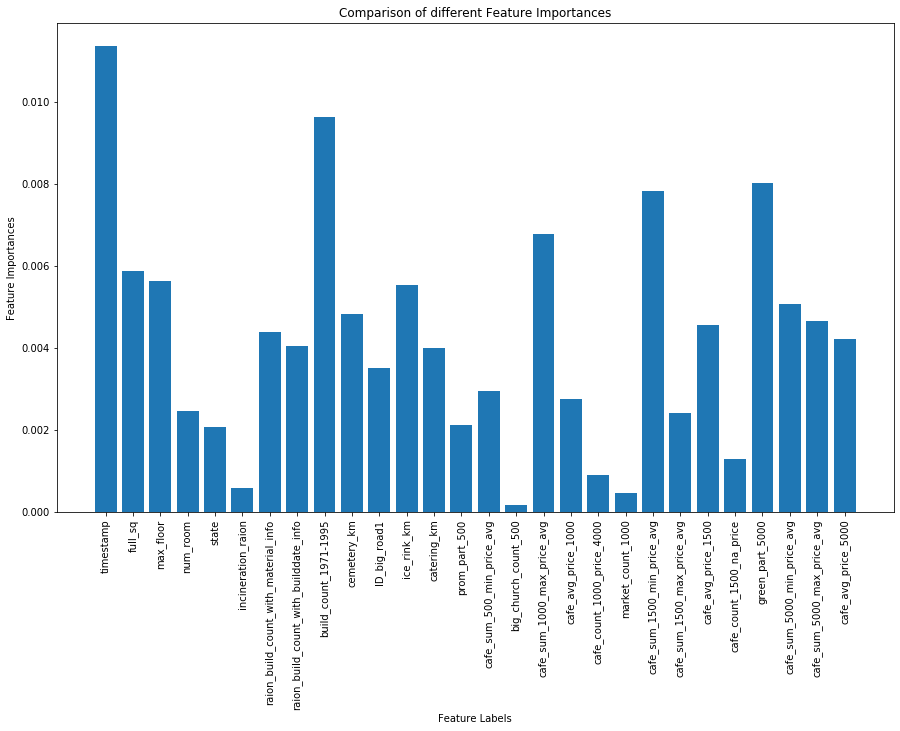

In [17]:
# Computing the importance of each feature 
feature_importance = extra_tree_forest.feature_importances_ 
  
# Normalizing the individual importances 
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        extra_tree_forest.estimators_], 
                                        axis = 0) 
imp_arr=[]
column_arr=[]

for i in range(len(data_shift_kl)):
  result = np.where(X.columns.values == data_shift_kl[i])
  
  j=result[0][0]
  imp_arr.append(feature_importance_normalized[j])

for item in X.columns:
  if(feature_importance_normalized[i]<0.005):
    column_arr.append(item)
#-------------------------------------------------------
# Plotting a Bar Graph to compare the models 
fig = plt.figure(figsize=(15,9))
plt.bar(data_shift_kl,imp_arr)
#plt.bar(X.columns, feature_importance_normalized)
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances')
plt.xticks(rotation='vertical')
plt.title('Comparison of different Feature Importances') 

plt.show()


In [18]:
#del_features=['material', 'build_year', 'incineration_raion', 'raion_build_count_with_material_info','build_count_1971-1995', 'cemetery_km', 'ID_big_road1','office_km', 'big_church_count_500', 'cafe_sum_1000_min_price_avg','cafe_count_1000_price_4000','cafe_count_1500_na_price','cafe_avg_price_5000']

#del_features=column_arr

X_new=X.copy()
X_test_new=X_test.copy()
y_new=y.copy()

#--------------------------------------
for i in range(len(data_shift_kl)):
  
  if(imp_arr[i]<0.04):
    del X_new[data_shift_kl[i]]
    del X_test_new[data_shift_kl[i]]
#------------------------------------------
'''
for ftr in del_features:
  if(ftr in X_new.columns):
    del X_new[ftr]
    del X_test_new[ftr]
'''
#--------------------------------
# Training the model 
extra_tree_forest.fit(X_new, y_new)
y_pred=extra_tree_forest.predict(X_test_new)
score=accuracy_score(y_new,y_pred)
 
print(score)
  

0.005
